#4. 이미지 Augmentation

참고 깃허브 https://hoya012.github.io/blog/Image-Data-Augmentation-Overview/

## 4.1) 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### tfds.load 인자
 - split을 통해 train, test 변수 선언 가능
 - with_info=True 를 통해 변수에 feature정보 데이터 크기등 정보 저장 가능

    (데이터셋에 문서 파일로 저장되나봄)
 - shuffle_files 옵션을 주면, 로드 할 때 shuffle 수행
 - data_dir=('경로') 를 통해 데이터 저장 위치를 알 수 있다.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir=('/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/Data_augmentation/data')
)


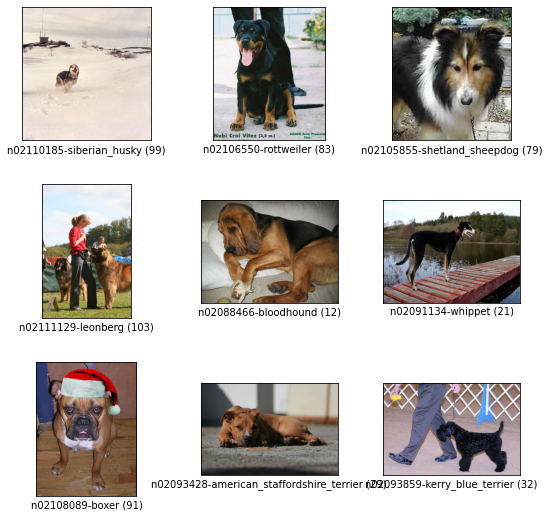

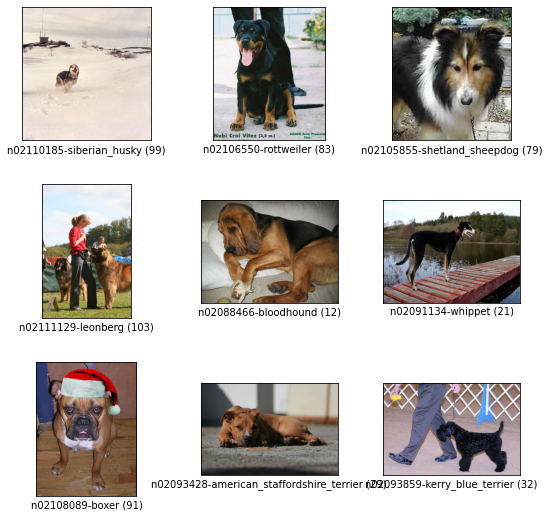

In [4]:
tfds.show_examples(ds_train, ds_info)

## 4.2) Augmentation 적용하기

### 노말라이즈 및 리사이즈함수 정의
1. 인수로 변환할 이미지와 레이블을 받음
2. 리사이즈를 통해 크기 조절 -> tf.image.resize(이미지 인수, [픽셀]
3. 이미지 타입 변경, /255를 통해 노말라이즈 결과를 반환-> tf.cast(이미지 인수, tf.바꿀 타입)


In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

### augment 함수 정의
1. 인수로 변환할 이미지와 레이블을 받음
2. 이미지에 적절한 Augmentation API들을 적용
 - random_brightness() : 밝기 랜덤 조절 (image, delta(0+))
 - random_contrast() : 대비 조절 (image, delta하한, delta상한)
 - random_crop() : 무작위 자르기 (value=image, size=(x, y)
 - random_flip_left_right() : 좌우 뒤집기
 - random_flip_up_down() : 상하 뒤집기
 - random_hue() : 색조 랜점 조절 (image, max_delta)
 - random_jpeg_quality() : 이미지 노이즈 추가 (image, 최소노이즈품질[0], 최대노이즈품질[100])
 - random_saturation() : 무작위 채도 (image, 계수 하한, 계수 상한)
3. 이미지와 레이블을 반환

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### 데이터셋 가공 함수 정의
1. 인수로 데이터셋, 테스트셋 판단, 표본 사이즈, 'with_aug' augmentation적용여부 확인 매개변수 지정
2. 일단 노말라이즈 및 리사이즈(전처리) 함수 전체 적용
3. 테스트가 아니고, with_aug에 해당하면 augment 함수 적용
4. 배치 사이즈 지정, 데이터들을 배치사이즈 개수로 분할함
 - ex) 데이터수 1000 / batch_size = 100이면 데이터를 100개씩 10묶음으로 지정
5. repeat() : 인수가 없으면 무한대로 반복, 데이터를 저장하는 것이 아니라
   제너레이터 형식으로 번호표만 저장하나봄
6. shuffle() : 배치사이즈로 묶어진 그룹을 셔플해서 개수만큼 저장해둠
5. 테스트셋이 아니면 반복
6. 데이터 셋을 반환

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### augment 함수 정하기 실습
 - 각 API 인수들 체크 (외우긴 힘들듯)

In [8]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

### RasNet50, Imagenet 훈련 모델 불러오기
 - 2개로 나눈뒤 매개변수 with_aug의 불리언 값을 통해 구분해서 진행

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 2s 0us/step


In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete27H8PE/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete27H8PE/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## 4.3) Augmentation 비교 실험

In [12]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 108s 120ms/step - loss: 2.2020 - accuracy: 0.4506 - val_loss: 3.2531 - val_accuracy: 0.2303
Epoch 2/3
750/750 [==============================] - 94s 125ms/step - loss: 0.6844 - accuracy: 0.8170 - val_loss: 1.0580 - val_accuracy: 0.6918
Epoch 3/3
750/750 [==============================] - 89s 118ms/step - loss: 0.1906 - accuracy: 0.9641 - val_loss: 0.9273 - val_accuracy: 0.7305


In [13]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 97s 119ms/step - loss: 2.2933 - accuracy: 0.4235 - val_loss: 2.8605 - val_accuracy: 0.2871
Epoch 2/3
750/750 [==============================] - 88s 118ms/step - loss: 0.9202 - accuracy: 0.7382 - val_loss: 1.4063 - val_accuracy: 0.5943
Epoch 3/3
750/750 [==============================] - 88s 118ms/step - loss: 0.4715 - accuracy: 0.8759 - val_loss: 1.1066 - val_accuracy: 0.6744


### 시각화 비교

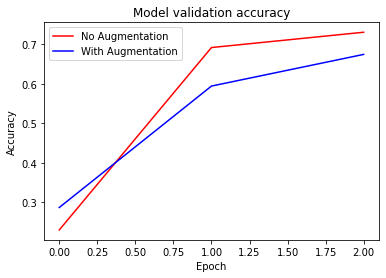

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

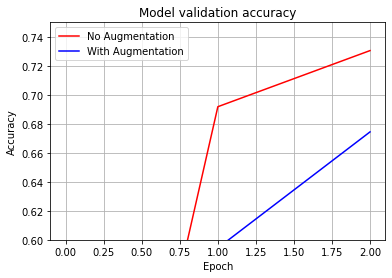

In [15]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.75)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## 4.4) Cutmix Augmentation 
 Cut(자르기)+Mix(섞기)에 해당
#### (1) 이미지 섞기
 plt.subplot(행, 열, 번호)

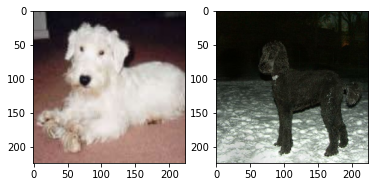

In [28]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

### 이미지 내부의 영역 지정 함수
이미지 a의 일부 영역에 이미지 b를 넣을 자리를 랜덤으로 만듬

예제에서 그림 크기는 [224, 224]로 표준화 해주었지만
일반화를 위해서 이미지 사이즈가 같지 않아도 적용가능한 함수를 만듬

tf.cast(원본, 변화값) 그림파일을 변환한 tensor를 변화값 dtype로 변환해줌)

암튼 수식을 통해서 적절한 위치의 x, y 좌표를 정해주는 듯함

In [18]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(49, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(84, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


### 그림 2개를 합치는 함수
 위 함수에서 그림의 x,y축의 min, max값을 구해주었으므로
그 자리를 y로 대체하면 됨

리스트 슬라이스를 자른 후
tf.concot(values, axis= ) values의 입력 텐서 데이터가 axis 차원에 따라 ~~융합~~ 합쳐짐

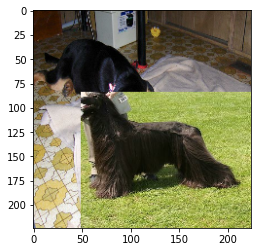

In [19]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 레이블 섞기
섞은 클래스 레이블이 1, 0 일때 비율이 6:4라면 레이블을 0.6으로 맞춰주는 식인 듯

In [20]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.48828125,
       0.        , 0.        , 0.        , 0.        , 0.51171875,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

### mix 2 image, mix 2 label 두 함수 혼합 함수


In [21]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 4.5) Mixup Augmentation
Mixup은 위처럼 그림을 잘라 붙이는 것이 아니라 정해진 비율에 따라 픽셀을 혼합하는 형태를 가지고 있다.

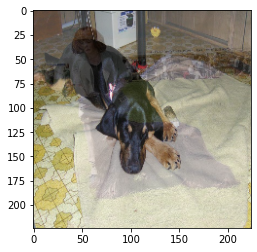

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.24479377 0.         0.
 0.         0.         0.7552062  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [22]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [23]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


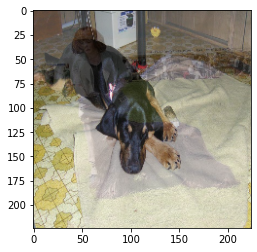

In [24]:
plt.imshow(mixed_img.numpy())
plt.show()

#여기서부터 프로젝트 실습
## 4.7) CutMix 또는 Mixup 비교실험 하기

In [6]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [7]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir=('/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/Data_augmentation/data')
)

### 4.7.1) Augmentation을 적용한 데이터셋 만들기

In [19]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    else:
        pass
        
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label



In [10]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [12]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 4.7.2) 모델 만들기

1. 아무 작업도 안한 데이터셋
2. 일반적인 augment만 수행한 데이터셋
3. 기본 + CutMix를 거친 데이터셋
4. 기본 + Mixup을 거친 데이터셋

4개의 결과값을 비교해야함


(1) 기본데이터 셋 (ds_train, ds_test)


with_aug=False, with_cutmix=False 로 함수를 지나게 하면 될듯
 - normalize_and_resize_img 함수만 통과함

(2) 기본 augment만 수행한 데이터셋
with_aug=True, with_cutmix=False
 - normalize_and_resize_img 통과
 - augment를 통과해 기본 augment가 수행됨

(3) 기본 augment + cutmix
with_aug=True, with_cutmix=True
 - normalize_and_resize_img 통과
 - augment를 통과해 기본 augment가 수행됨
 - 이번엔 cutmix 함수도 적용되어야함

 #근데 mixup루프가 없어서 함수 재정의 해줘야할듯

In [24]:
def onehot(image, label, batch_size=16, num_classes=120):
    labellist = []
    labellist.append(label)
    label = tf.one_hot(labellist, depth=120)
    label = tf.reshape(tf.stack(label), (batch_size, num_classes))
    return image, label

In [31]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2  
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

(4) 기본 augment + mixup
with_aug=True, with_mixup=True
 - normalize_and_resize_img 통과
 - augment를 통과해 기본 augment가 수행됨
 - 이번엔 cutmix 함수도 적용되어야함

> 위 함수를 지나게 되면

(1), (2)의 경우 label은 스칼라값

(3), (4)의 경우 one_hot을 거친 텐서가 나오는데.

어차피 별개 데이터셋이라고 판단 별도의 output을 맞추는 작업은 생략하고 진행하도록 하겠음

### 4.7.3) 모델 훈련하기

In [15]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [16]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [29]:
import matplotlib.pyplot as plt

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

In [33]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [39]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 97s 118ms/step - loss: 0.0205 - accuracy: 0.9989 - val_loss: 0.9155 - val_accuracy: 0.7503
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0088 - accuracy: 0.9986 - val_loss: 0.8945 - val_accuracy: 0.7542
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0058 - accuracy: 0.9996 - val_loss: 0.8870 - val_accuracy: 0.7564
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 0.8831 - val_accuracy: 0.7590
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 0.8860 - val_accuracy: 0.7565
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.8845 - val_accuracy: 0.7596
Epoch 7/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8875 - val_accuracy: 0.7

In [41]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50.fit(
    ds_train_aug, # augment만 사용한 데이터로 확인
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 149s 119ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.9111 - val_accuracy: 0.7611
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.9130 - val_accuracy: 0.7632
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.9120 - val_accuracy: 0.7621
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.9120 - val_accuracy: 0.7621
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9122 - val_accuracy: 0.7622
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.9167 - val_accuracy: 0.7642
Epoch 7/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.9127 - val_accuracy: 0.

In [34]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy', #레이블이 벡터이므로 로스함수도 이거로
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = resnet50.fit(
    ds_train_cutmix, # augment + cutmix 사용한 데이터로 확인
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 106s 120ms/step - loss: 3.8945 - accuracy: 0.2017 - val_loss: 3.7790 - val_accuracy: 0.1771
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 3.0356 - accuracy: 0.4083 - val_loss: 1.6347 - val_accuracy: 0.5475
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 2.7705 - accuracy: 0.4813 - val_loss: 1.2594 - val_accuracy: 0.6440
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 2.5793 - accuracy: 0.5460 - val_loss: 1.2045 - val_accuracy: 0.6667
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 2.4479 - accuracy: 0.5843 - val_loss: 1.1617 - val_accuracy: 0.6732
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 2.3445 - accuracy: 0.6202 - val_loss: 1.1448 - val_accuracy: 0.6786
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2435 - accuracy: 0.6545 - val_loss: 1.1956 - val_accuracy: 0.

In [35]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy', #레이블이 벡터이므로 로스함수도 이거로
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = resnet50.fit(
    ds_train_mixup, # augment + mixup 사용한 데이터로 확인
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 103s 126ms/step - loss: 1.9568 - accuracy: 0.8100 - val_loss: 1.9578 - val_accuracy: 0.5352
Epoch 2/20
750/750 [==============================] - 94s 125ms/step - loss: 1.9186 - accuracy: 0.8198 - val_loss: 1.4890 - val_accuracy: 0.6318
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 1.8656 - accuracy: 0.8270 - val_loss: 1.4464 - val_accuracy: 0.6489
Epoch 4/20
750/750 [==============================] - 90s 119ms/step - loss: 1.8337 - accuracy: 0.8347 - val_loss: 1.6804 - val_accuracy: 0.6077
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 1.8263 - accuracy: 0.8354 - val_loss: 1.3049 - val_accuracy: 0.6796
Epoch 6/20
750/750 [==============================] - 92s 122ms/step - loss: 1.8119 - accuracy: 0.8402 - val_loss: 1.3009 - val_accuracy: 0.6767
Epoch 7/20
750/750 [==============================] - 91s 122ms/step - loss: 1.7795 - accuracy: 0.8529 - val_loss: 1.3451 - val_accuracy: 0.

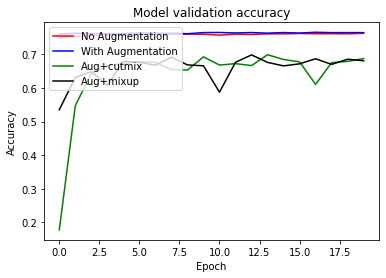

In [43]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Aug+cutmix', 'Aug+mixup'], loc='upper left')
plt.show()

### 4.7.5) Augmentation에 의한 모델 성능 비교

자꾸 런타임 오류가 발생하는 바람에 그래프상 No Augment, With Augment가 Epoch가 더 진행된 결과로 나오긴 했지만, 

어차피 추이를 확인했을때, 저 부근에서 과적합으로 더이상 안오르는 것을 확인했기 때문에

(실제로 로스 값도 0에 수렴중이다)

단순 Aug만 사용하거나 아예 사용하지 않았을때의 어큐러시가 더 높은건 확인 할 수 있었다.

사람으로 예를 들자면, 어그멘테이션을 해준다는건 일부러 문제를 어렵게 내서

테스트에서의 성능을 떨어뜨리는 대신 일반화를 더 자연스럽게 하도록 학습을 시키는 것이니 

이러한 결과는 당연하다고 생각된다.

논문에서는 20epoch 정도로는 어림도 없고 한 2000epoch정도 간다면 이러한 augmentation이 더 높은 validation accuracy를 가진다고 하는데.....

이쯤 되면 효율성 측면에서 무의미에 가깝다고 할 수도 있다고 생각한다.

종합적으로 직관적으로 생각한 augmentation에 대한 회의감은 지워지지 않는다.

개인적으로는 dropout의 하위호환일 뿐이고, 혹은 데이터가 너무나 부족한 경우에 쓸 수있는 미봉책 정도가 아닐까 생각한다.

사진에 변화를 조금 줄 수 있을지라도, 그 사진에 가할 수 있는 모든 변화의 스펙트럼을 모두 적용할 수도 없을 뿐더러, 이정도로 많은 학습을 지속해야만 성능이 증가한다면 실생활에 적용시키기는 매우 어려울 것이기 때문이다.